In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
from celluloid import Camera
from collections import deque
from matplotlib import animation

from controllers.game_controller import GameController
from drl.agent import DRLAgent
from models.players.random_player import RandomPlayer
from models.players.drl_player import DRLPlayer
from utils import get_reward_from_winner

# %matplotlib notebook
plt.rcParams['animation.ffmpeg_path'] = "C:\\FFmpeg\\bin\\ffmpeg"

In [3]:
def run_validation(players, n_episodes_validation):
    game_controller = GameController()
    game_controller.load_validation(players)
    
    # Disable train mode
    players[0].train_mode = False

    validation_scores = []
    for i in range(1, n_episodes_validation+1):
        episode_winner = game_controller.run_episode(eval_mode=True)
        validation_score = get_reward_from_winner(0, episode_winner)
        validation_scores.append(validation_score)
        game_controller.game.reset()

    # Re-enable train mode
    players[0].train_mode = True
    
    return np.mean(validation_scores)

In [4]:
def get_critic_value(agent_critic, initial_state, bid, board_move):
    action = torch.zeros(10)
    action[0] = bid/200
    action[1+board_move] = 1
    action = action.unsqueeze(0).cuda()
    return agent_critic(initial_state, action).flatten().item()

def get_all_critic_values(drl_player, initial_state):
    agent_critic = drl_player.agent.agent.critic_local
    return [[get_critic_value(agent_critic, initial_state, bid, board_move) for bid in range(101)] \
                for board_move in range(9)]   

In [5]:
def plot_critic_values(drl_player, critic_values, fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots(3, 3, figsize=(12, 8))
    for board_move in range(9):
        axx = ax[board_move//3, board_move%3]
        axx.set_xlabel('Bid value')
        axx.set_ylabel('Quality of move')
        axx.set_title(f'Board move {board_move}')
        axx.plot(critic_values[board_move])
    fig.tight_layout()
#     plt.savefig('test.png')

In [6]:
def create_animation(critic_values_by_episode, drl_player, fps=10, filename='critic_values.mp4'):
    fig, ax = plt.subplots(3, 3, figsize=(12, 8))

    camera = Camera(fig)
    initial_index = 0
    while initial_index+1<len(critic_values_by_episode) and \
            critic_values_by_episode[initial_index] == critic_values_by_episode[initial_index+1]:
        initial_index += 1

    for i in range(initial_index, len(critic_values_by_episode)):
        critic_values = critic_values_by_episode[i]
        i += 1
        plot_critic_values(drl_player, critic_values, fig, ax);
        plt.pause(0.1)
        camera.snap()

    anim = camera.animate()
    FFwriter = animation.FFMpegWriter(fps=fps)
    anim.save(filename, writer=FFwriter);

In [7]:
def init_train(game_controller, players, n_episodes, checkpoint_each, validate_each, n_episodes_validation,
                   model_path=None, save_critic_value_each=100, save_animation_each=1000, eps_start=1.0,
                   eps_end=0.01, eps_decay=0.999, start_epoch=1, critic_values_by_episode=None):

        game_controller.load_train(players)
        players[0].update_epsilon(eps_start)

        if critic_values_by_episode is None:
            critic_values_by_episode = []
        initial_state = players[0]._format_state_to_agent(game_controller.game.get_state_array()).cuda().unsqueeze(0)

        try:
            validation_scores = []
            validation_scores_window = deque(maxlen=100)
            eps = eps_start
            start = time.time()
            for i in range(start_epoch, start_epoch+n_episodes):
                game_controller.players[0].update_epsilon(eps)

                episode_winner = game_controller.run_episode(train_mode=True)
                game_controller.game.reset()

                # Update epsilon-greedy parameter
                eps = max(eps_end, eps * eps_decay)

                if i%validate_each == 0:
                    mean_validation_score = run_validation(players, n_episodes_validation)

                    validation_scores.append(mean_validation_score)
                    validation_scores_window.append(mean_validation_score)
                    mean_validation_score_last_runs = np.mean(validation_scores_window)

                    try:
                        agent_losses = players[0].agent.get_losses()
                        actor_loss = '{:+6.3f}'.format(agent_losses['actor_losses'][-1])
                        critic_loss = '{:+6.3f}'.format(agent_losses['critic_losses'][-1])
                    except:
                        actor_loss = '------'
                        critic_loss = '------'
                    print("\rEpisode #{:4d}  |  "
                        "Val. Score: {:+5.2f}   |  "
                        "Avg. Val. Score: {:+5.2f}  |  "
                        "Epsilon: {:5.3f}\n"
                        "                  "
                        "Actor Loss: {}  |  "
                        "Critic Loss: {}     |  "
                        "Time Elapsed: {:.2f}s".format(i, mean_validation_score,
                                            mean_validation_score_last_runs, eps,
                                            actor_loss, critic_loss, time.time() - start)
                    )

                if checkpoint_each != -1 and i%checkpoint_each == 0:
                    players[0].agent.save_model(f'../checkpoints/checkpoint_episode_{i}_v3.pt')
                    print('Checkpoint saved!')
                if save_critic_value_each != -1 and i%save_critic_value_each == 0:
                    critic_values_by_episode.append(get_all_critic_values(players[0], initial_state))
                if save_animation_each != -1 and i%save_animation_each == 0:
                    create_animation(critic_values_by_episode, players[0], filename=f'critic_values_episode_{i}_v3.mp4')
                    print('Animation of critic values saved!')
        except KeyboardInterrupt:
            pass

        # save model after all episodes
        players[0].agent.save_model(model_path)
        print('Model saved!')

        return validation_scores, critic_values_by_episode

In [8]:
def plot_scores(metrics, validate_each):
    new_index = pd.RangeIndex(start=1, stop=1+len(metrics)*validate_each, step=validate_each)
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(new_index, metrics)
    series = pd.Series(metrics)
    series.index = new_index
    series.rolling(100, 1).mean().plot(ax=ax, label='MA(100)')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Score')
    plt.show();

In [9]:
controller = GameController()
drl_agent = DRLAgent(
    state_size=controller.game.N*controller.game.N+2,
    bid_action_size=1,
    board_action_size=controller.game.N*controller.game.N,
    seed=None,
    checkpoint_path='../checkpoints/checkpoint_v3.pt'
)

Episode # 100  |  Val. Score: +0.20   |  Avg. Val. Score: +0.20  |  Epsilon: 0.905
                  Actor Loss: ------  |  Critic Loss: ------     |  Time Elapsed: 1.17s
Episode # 200  |  Val. Score: -0.40   |  Avg. Val. Score: -0.10  |  Epsilon: 0.819
                  Actor Loss: -0.156  |  Critic Loss: +0.059     |  Time Elapsed: 44.60s
Episode # 300  |  Val. Score: -0.20   |  Avg. Val. Score: -0.13  |  Epsilon: 0.741
                  Actor Loss: -0.235  |  Critic Loss: +0.066     |  Time Elapsed: 98.65s
Episode # 400  |  Val. Score: -0.50   |  Avg. Val. Score: -0.23  |  Epsilon: 0.670
                  Actor Loss: -0.313  |  Critic Loss: +0.063     |  Time Elapsed: 156.12s
Episode # 500  |  Val. Score: +0.40   |  Avg. Val. Score: -0.10  |  Epsilon: 0.606
                  Actor Loss: -0.428  |  Critic Loss: +0.064     |  Time Elapsed: 211.08s
Checkpoint saved!


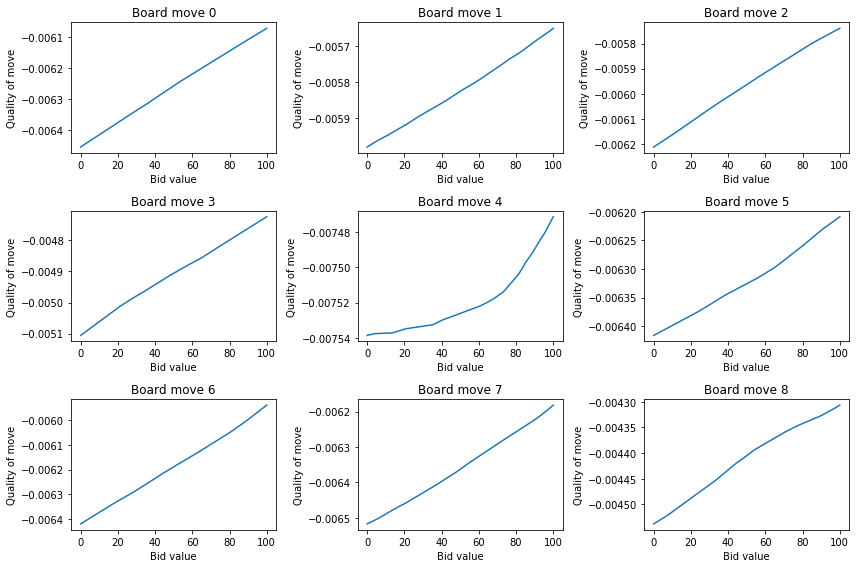

Animation of critic values saved!
Episode # 600  |  Val. Score: -0.10   |  Avg. Val. Score: -0.10  |  Epsilon: 0.549
                  Actor Loss: -0.575  |  Critic Loss: +0.074     |  Time Elapsed: 271.84s
Episode # 700  |  Val. Score: +0.50   |  Avg. Val. Score: -0.01  |  Epsilon: 0.496
                  Actor Loss: -0.748  |  Critic Loss: +0.072     |  Time Elapsed: 330.29s
Episode # 800  |  Val. Score: -0.30   |  Avg. Val. Score: -0.05  |  Epsilon: 0.449
                  Actor Loss: -0.996  |  Critic Loss: +0.121     |  Time Elapsed: 387.19s
Episode # 900  |  Val. Score: -0.30   |  Avg. Val. Score: -0.08  |  Epsilon: 0.406
                  Actor Loss: -1.511  |  Critic Loss: +0.251     |  Time Elapsed: 445.34s
Episode #1000  |  Val. Score: -0.40   |  Avg. Val. Score: -0.11  |  Epsilon: 0.368
                  Actor Loss: -2.046  |  Critic Loss: +0.441     |  Time Elapsed: 499.15s
Checkpoint saved!


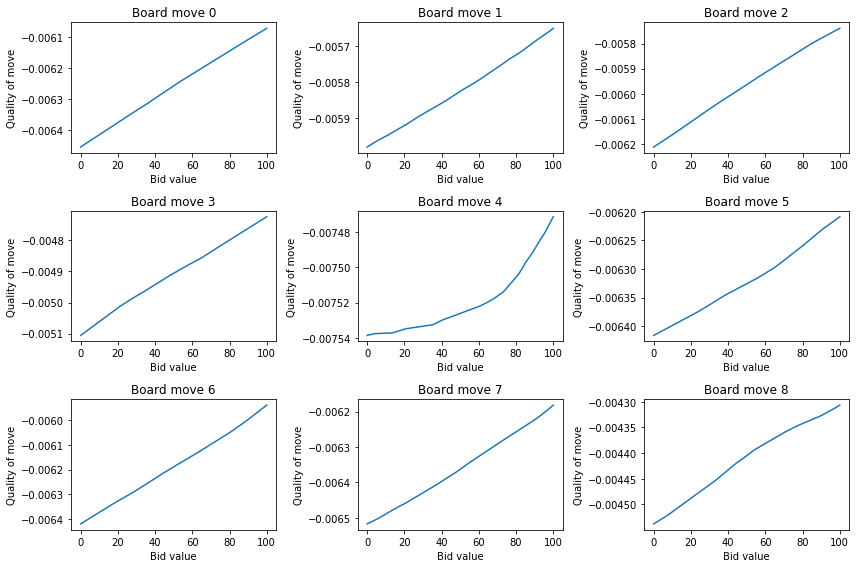

Animation of critic values saved!
Episode #1100  |  Val. Score: +0.60   |  Avg. Val. Score: -0.05  |  Epsilon: 0.333
                  Actor Loss: -2.447  |  Critic Loss: +0.590     |  Time Elapsed: 557.17s
Episode #1200  |  Val. Score: -0.10   |  Avg. Val. Score: -0.05  |  Epsilon: 0.301
                  Actor Loss: -2.782  |  Critic Loss: +0.842     |  Time Elapsed: 610.80s
Episode #1300  |  Val. Score: -0.30   |  Avg. Val. Score: -0.07  |  Epsilon: 0.272
                  Actor Loss: -3.182  |  Critic Loss: +1.092     |  Time Elapsed: 664.24s
Episode #1400  |  Val. Score: -0.20   |  Avg. Val. Score: -0.08  |  Epsilon: 0.246
                  Actor Loss: -3.504  |  Critic Loss: +1.304     |  Time Elapsed: 717.72s
Episode #1500  |  Val. Score: -0.30   |  Avg. Val. Score: -0.09  |  Epsilon: 0.223
                  Actor Loss: -3.698  |  Critic Loss: +1.301     |  Time Elapsed: 771.42s
Checkpoint saved!


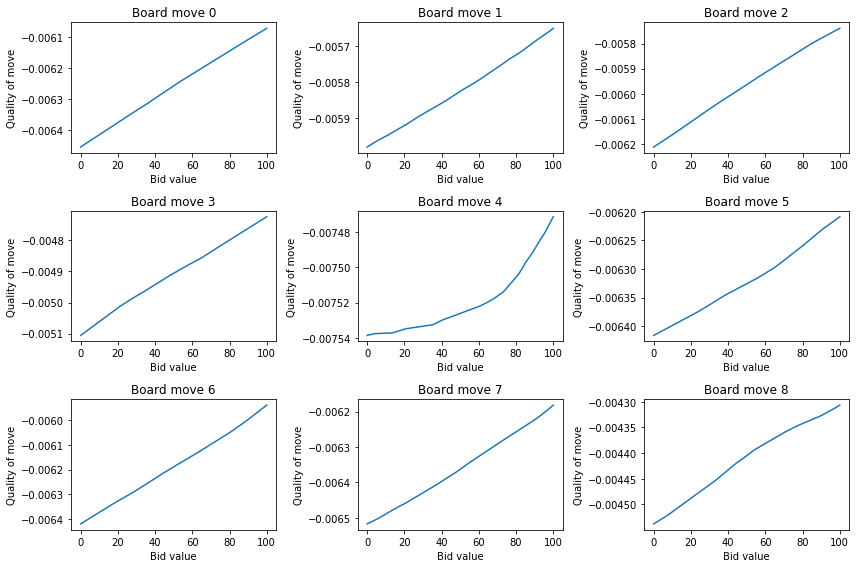

Animation of critic values saved!
Episode #1600  |  Val. Score: +0.60   |  Avg. Val. Score: -0.05  |  Epsilon: 0.202
                  Actor Loss: -3.860  |  Critic Loss: +1.562     |  Time Elapsed: 832.81s
Episode #1700  |  Val. Score: -0.20   |  Avg. Val. Score: -0.06  |  Epsilon: 0.183
                  Actor Loss: -4.046  |  Critic Loss: +1.932     |  Time Elapsed: 891.43s
Episode #1800  |  Val. Score: -0.10   |  Avg. Val. Score: -0.06  |  Epsilon: 0.165
                  Actor Loss: -4.193  |  Critic Loss: +1.769     |  Time Elapsed: 949.79s
Episode #1900  |  Val. Score: +0.00   |  Avg. Val. Score: -0.06  |  Epsilon: 0.149
                  Actor Loss: -4.240  |  Critic Loss: +2.125     |  Time Elapsed: 1009.29s
Episode #2000  |  Val. Score: +0.00   |  Avg. Val. Score: -0.06  |  Epsilon: 0.135
                  Actor Loss: -4.339  |  Critic Loss: +1.972     |  Time Elapsed: 1066.02s
Checkpoint saved!


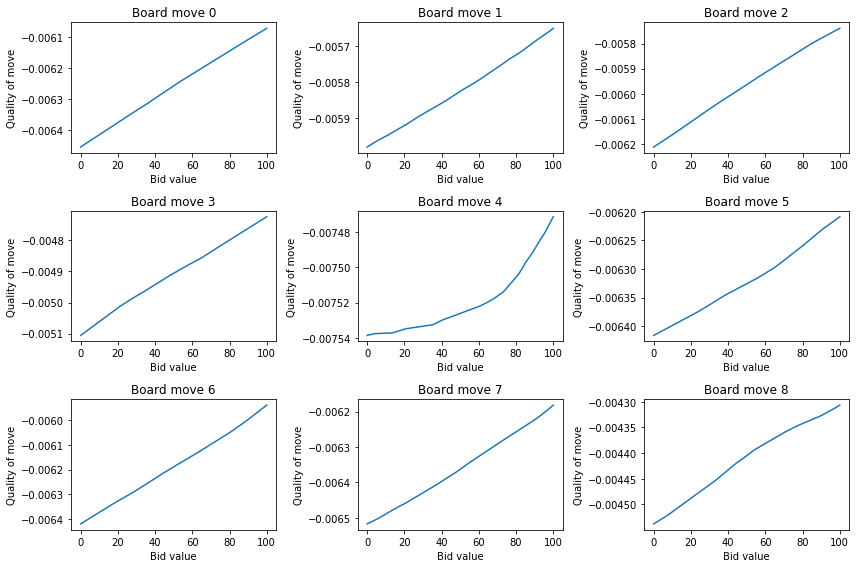

Animation of critic values saved!
Episode #2100  |  Val. Score: +0.60   |  Avg. Val. Score: -0.02  |  Epsilon: 0.122
                  Actor Loss: -4.613  |  Critic Loss: +2.013     |  Time Elapsed: 1130.30s
Episode #2200  |  Val. Score: +0.40   |  Avg. Val. Score: -0.00  |  Epsilon: 0.111
                  Actor Loss: -4.780  |  Critic Loss: +2.337     |  Time Elapsed: 1186.64s
Episode #2300  |  Val. Score: +0.10   |  Avg. Val. Score: -0.00  |  Epsilon: 0.100
                  Actor Loss: -5.134  |  Critic Loss: +2.337     |  Time Elapsed: 1243.68s
Episode #2400  |  Val. Score: -0.80   |  Avg. Val. Score: -0.03  |  Epsilon: 0.091
                  Actor Loss: -5.444  |  Critic Loss: +3.712     |  Time Elapsed: 1303.87s
Episode #2500  |  Val. Score: +0.20   |  Avg. Val. Score: -0.02  |  Epsilon: 0.082
                  Actor Loss: -5.570  |  Critic Loss: +4.281     |  Time Elapsed: 1362.80s
Checkpoint saved!


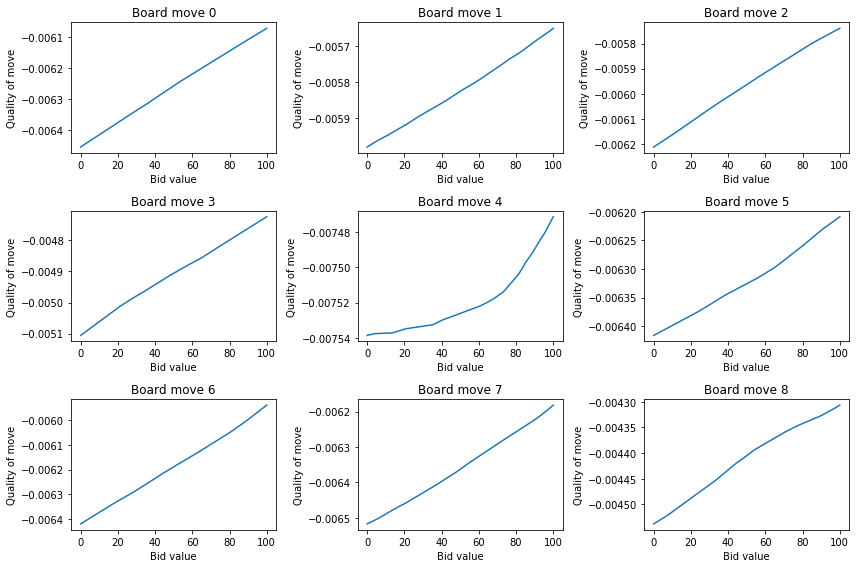

Animation of critic values saved!
Episode #2600  |  Val. Score: +0.20   |  Avg. Val. Score: -0.02  |  Epsilon: 0.074
                  Actor Loss: -5.859  |  Critic Loss: +3.711     |  Time Elapsed: 1432.85s
Episode #2700  |  Val. Score: +0.20   |  Avg. Val. Score: -0.01  |  Epsilon: 0.067
                  Actor Loss: -6.068  |  Critic Loss: +4.157     |  Time Elapsed: 1492.14s
Episode #2800  |  Val. Score: -0.20   |  Avg. Val. Score: -0.01  |  Epsilon: 0.061
                  Actor Loss: -6.187  |  Critic Loss: +4.625     |  Time Elapsed: 1550.94s
Episode #2900  |  Val. Score: -0.10   |  Avg. Val. Score: -0.02  |  Epsilon: 0.055
                  Actor Loss: -6.348  |  Critic Loss: +4.331     |  Time Elapsed: 1608.32s
Episode #3000  |  Val. Score: +0.00   |  Avg. Val. Score: -0.02  |  Epsilon: 0.050
                  Actor Loss: -6.445  |  Critic Loss: +4.976     |  Time Elapsed: 1664.73s
Checkpoint saved!


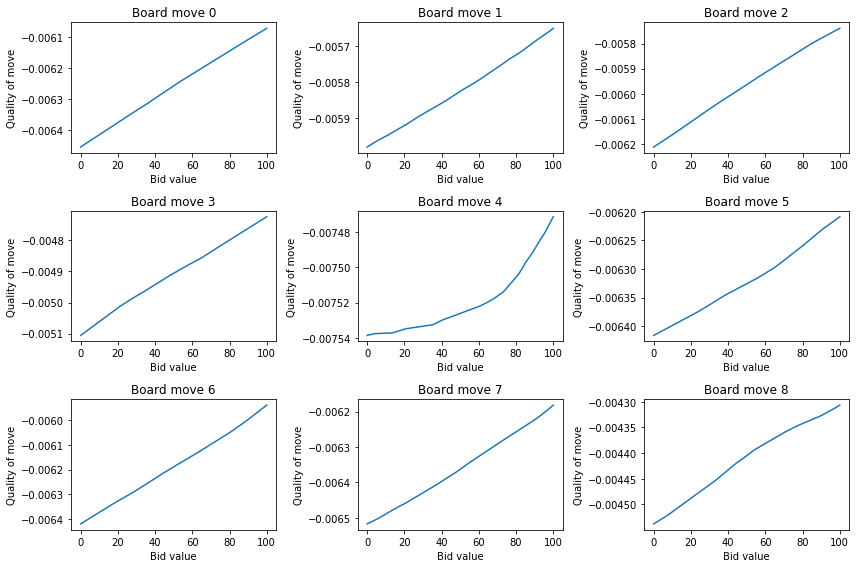

Animation of critic values saved!
Episode #3100  |  Val. Score: -0.60   |  Avg. Val. Score: -0.04  |  Epsilon: 0.045
                  Actor Loss: -6.472  |  Critic Loss: +4.946     |  Time Elapsed: 1732.44s
Episode #3200  |  Val. Score: +0.10   |  Avg. Val. Score: -0.03  |  Epsilon: 0.041
                  Actor Loss: -6.435  |  Critic Loss: +5.213     |  Time Elapsed: 1788.79s
Episode #3300  |  Val. Score: -0.20   |  Avg. Val. Score: -0.04  |  Epsilon: 0.037
                  Actor Loss: -6.351  |  Critic Loss: +5.343     |  Time Elapsed: 1843.96s
Episode #3400  |  Val. Score: -0.50   |  Avg. Val. Score: -0.05  |  Epsilon: 0.033
                  Actor Loss: -6.323  |  Critic Loss: +4.430     |  Time Elapsed: 1900.00s
Episode #3500  |  Val. Score: +0.00   |  Avg. Val. Score: -0.05  |  Epsilon: 0.030
                  Actor Loss: -6.162  |  Critic Loss: +4.097     |  Time Elapsed: 1957.91s
Checkpoint saved!


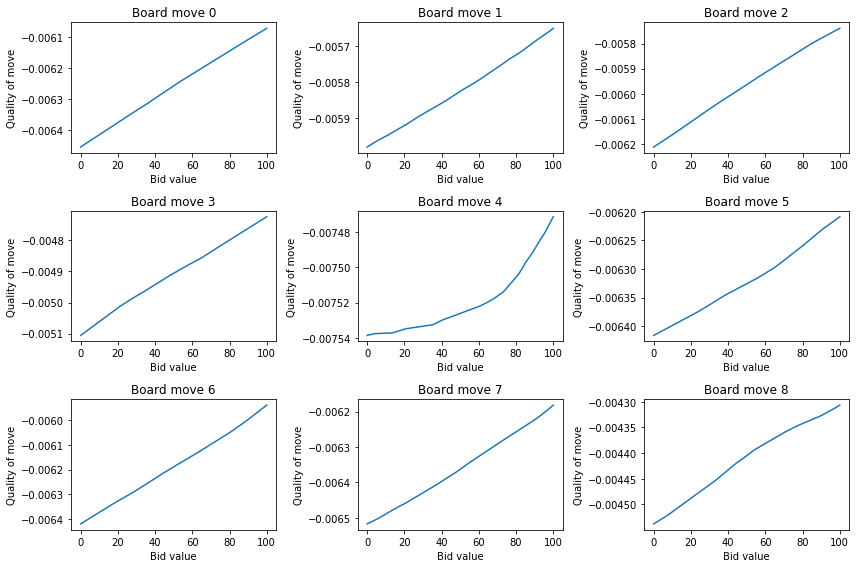

Animation of critic values saved!
Episode #3600  |  Val. Score: +0.10   |  Avg. Val. Score: -0.04  |  Epsilon: 0.027
                  Actor Loss: -5.966  |  Critic Loss: +4.523     |  Time Elapsed: 2032.84s
Episode #3700  |  Val. Score: +0.30   |  Avg. Val. Score: -0.04  |  Epsilon: 0.025
                  Actor Loss: -5.925  |  Critic Loss: +3.828     |  Time Elapsed: 2092.81s
Episode #3800  |  Val. Score: +0.40   |  Avg. Val. Score: -0.02  |  Epsilon: 0.022
                  Actor Loss: -5.637  |  Critic Loss: +3.538     |  Time Elapsed: 2152.94s
Episode #3900  |  Val. Score: +0.40   |  Avg. Val. Score: -0.01  |  Epsilon: 0.020
                  Actor Loss: -5.446  |  Critic Loss: +3.402     |  Time Elapsed: 2215.79s
Episode #4000  |  Val. Score: +0.10   |  Avg. Val. Score: -0.01  |  Epsilon: 0.018
                  Actor Loss: -5.192  |  Critic Loss: +3.407     |  Time Elapsed: 2277.17s
Checkpoint saved!


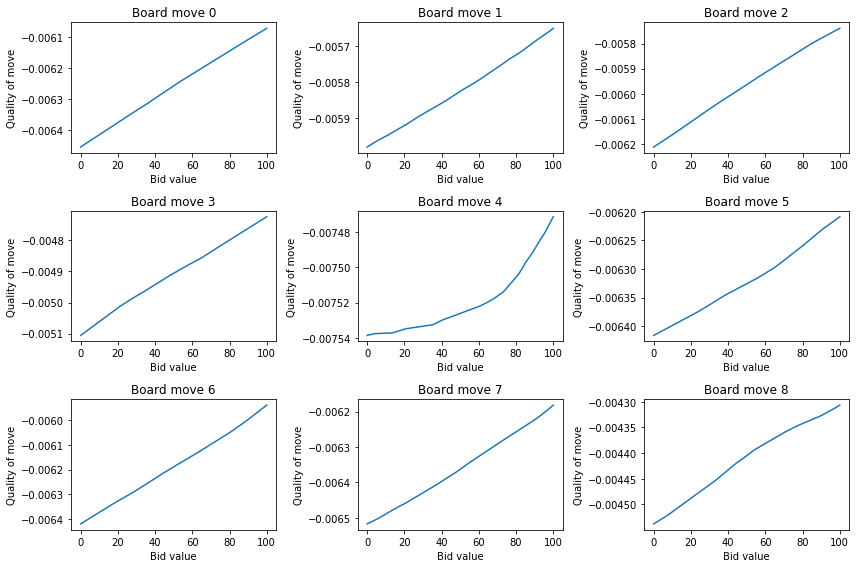

Animation of critic values saved!
Episode #4100  |  Val. Score: +0.20   |  Avg. Val. Score: -0.00  |  Epsilon: 0.017
                  Actor Loss: -5.131  |  Critic Loss: +3.023     |  Time Elapsed: 2353.92s
Episode #4200  |  Val. Score: +0.00   |  Avg. Val. Score: -0.00  |  Epsilon: 0.015
                  Actor Loss: -4.971  |  Critic Loss: +2.780     |  Time Elapsed: 2416.31s
Episode #4300  |  Val. Score: +0.40   |  Avg. Val. Score: +0.00  |  Epsilon: 0.014
                  Actor Loss: -4.641  |  Critic Loss: +2.609     |  Time Elapsed: 2477.38s
Episode #4400  |  Val. Score: +0.20   |  Avg. Val. Score: +0.01  |  Epsilon: 0.012
                  Actor Loss: -4.553  |  Critic Loss: +2.460     |  Time Elapsed: 2536.52s
Episode #4500  |  Val. Score: +0.10   |  Avg. Val. Score: +0.01  |  Epsilon: 0.011
                  Actor Loss: -4.405  |  Critic Loss: +2.083     |  Time Elapsed: 2596.94s
Checkpoint saved!


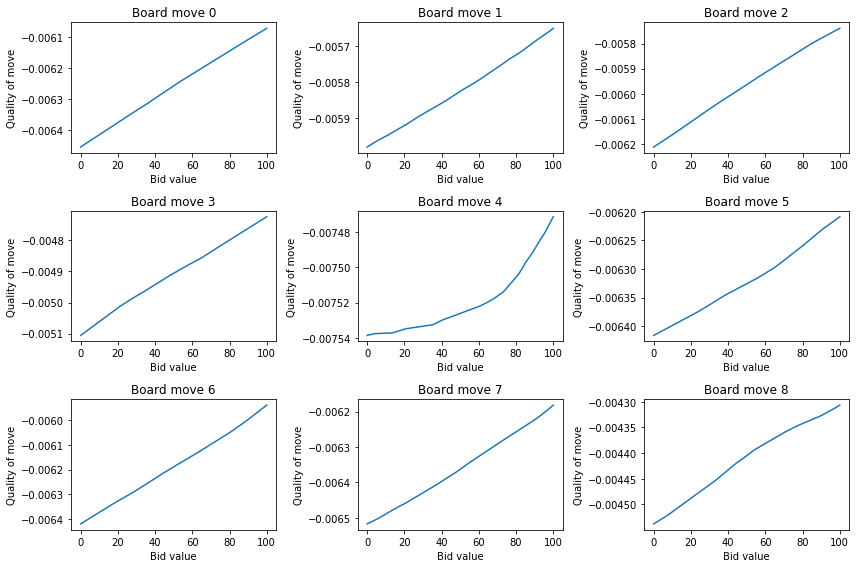

Animation of critic values saved!
Episode #4600  |  Val. Score: +0.40   |  Avg. Val. Score: +0.02  |  Epsilon: 0.010
                  Actor Loss: -4.249  |  Critic Loss: +1.920     |  Time Elapsed: 2675.18s
Episode #4700  |  Val. Score: +0.50   |  Avg. Val. Score: +0.03  |  Epsilon: 0.010
                  Actor Loss: -4.073  |  Critic Loss: +1.996     |  Time Elapsed: 2733.08s
Episode #4800  |  Val. Score: +0.20   |  Avg. Val. Score: +0.03  |  Epsilon: 0.010
                  Actor Loss: -3.908  |  Critic Loss: +1.802     |  Time Elapsed: 2792.90s
Episode #4900  |  Val. Score: +0.20   |  Avg. Val. Score: +0.04  |  Epsilon: 0.010
                  Actor Loss: -3.755  |  Critic Loss: +1.622     |  Time Elapsed: 2849.21s
Episode #5000  |  Val. Score: +0.50   |  Avg. Val. Score: +0.05  |  Epsilon: 0.010
                  Actor Loss: -3.595  |  Critic Loss: +1.327     |  Time Elapsed: 2905.15s
Checkpoint saved!


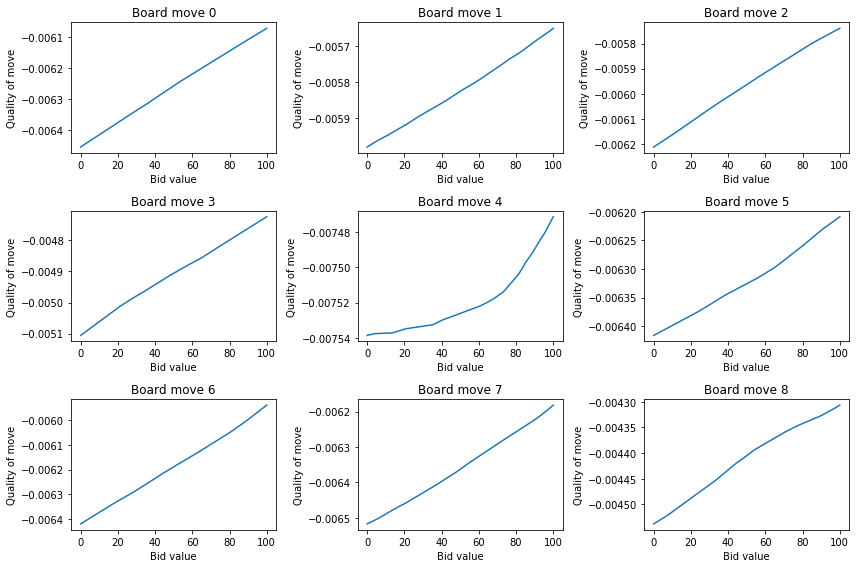

Animation of critic values saved!
Episode #5100  |  Val. Score: +0.20   |  Avg. Val. Score: +0.05  |  Epsilon: 0.010
                  Actor Loss: -3.417  |  Critic Loss: +1.260     |  Time Elapsed: 2981.92s
Episode #5200  |  Val. Score: +0.30   |  Avg. Val. Score: +0.05  |  Epsilon: 0.010
                  Actor Loss: -3.149  |  Critic Loss: +1.198     |  Time Elapsed: 3036.64s
Episode #5300  |  Val. Score: +0.30   |  Avg. Val. Score: +0.06  |  Epsilon: 0.010
                  Actor Loss: -2.952  |  Critic Loss: +0.991     |  Time Elapsed: 3092.72s
Episode #5400  |  Val. Score: +0.70   |  Avg. Val. Score: +0.07  |  Epsilon: 0.010
                  Actor Loss: -2.769  |  Critic Loss: +0.884     |  Time Elapsed: 3150.93s
Episode #5500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.08  |  Epsilon: 0.010
                  Actor Loss: -2.573  |  Critic Loss: +0.784     |  Time Elapsed: 3209.46s
Checkpoint saved!


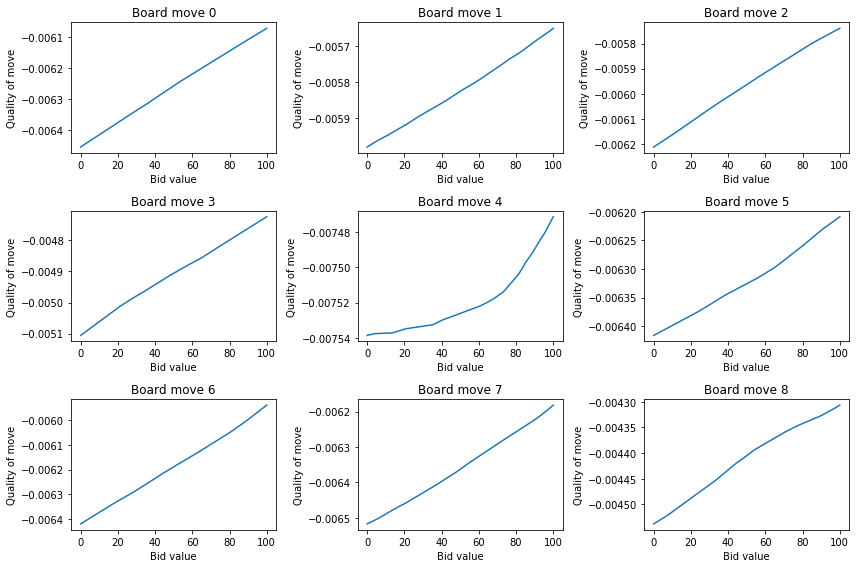

Animation of critic values saved!
Episode #5600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.09  |  Epsilon: 0.010
                  Actor Loss: -2.421  |  Critic Loss: +0.703     |  Time Elapsed: 3289.76s
Episode #5700  |  Val. Score: +0.10   |  Avg. Val. Score: +0.09  |  Epsilon: 0.010
                  Actor Loss: -2.227  |  Critic Loss: +0.624     |  Time Elapsed: 3348.05s
Episode #5800  |  Val. Score: +0.70   |  Avg. Val. Score: +0.10  |  Epsilon: 0.010
                  Actor Loss: -2.165  |  Critic Loss: +0.498     |  Time Elapsed: 3407.18s
Episode #5900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.11  |  Epsilon: 0.010
                  Actor Loss: -2.071  |  Critic Loss: +0.506     |  Time Elapsed: 3466.19s
Episode #6000  |  Val. Score: +0.50   |  Avg. Val. Score: +0.12  |  Epsilon: 0.010
                  Actor Loss: -1.944  |  Critic Loss: +0.415     |  Time Elapsed: 3524.47s
Checkpoint saved!


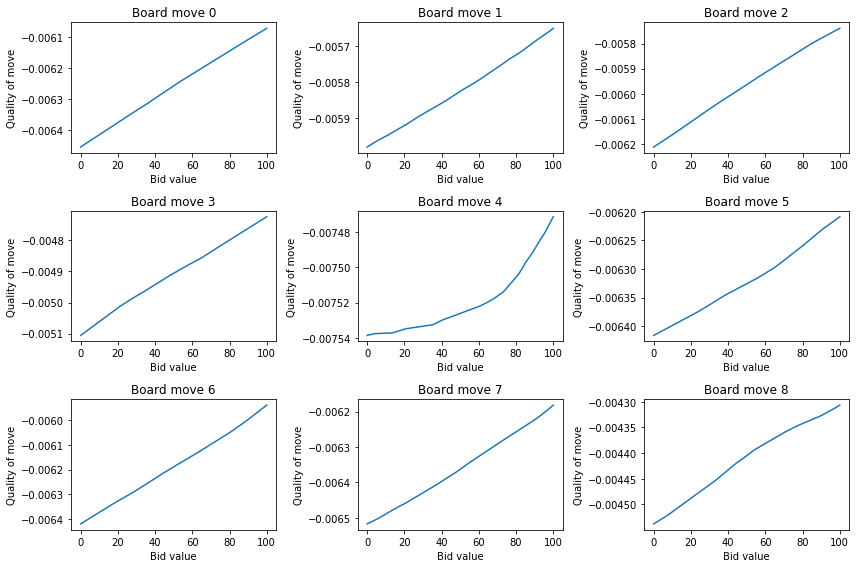

Animation of critic values saved!
Episode #6100  |  Val. Score: +0.40   |  Avg. Val. Score: +0.12  |  Epsilon: 0.010
                  Actor Loss: -1.819  |  Critic Loss: +0.395     |  Time Elapsed: 3607.00s
Episode #6200  |  Val. Score: -0.40   |  Avg. Val. Score: +0.12  |  Epsilon: 0.010
                  Actor Loss: -1.830  |  Critic Loss: +0.419     |  Time Elapsed: 3664.23s
Episode #6300  |  Val. Score: +0.20   |  Avg. Val. Score: +0.12  |  Epsilon: 0.010
                  Actor Loss: -1.686  |  Critic Loss: +0.365     |  Time Elapsed: 3723.35s
Episode #6400  |  Val. Score: +0.40   |  Avg. Val. Score: +0.12  |  Epsilon: 0.010
                  Actor Loss: -1.662  |  Critic Loss: +0.335     |  Time Elapsed: 3781.18s
Episode #6500  |  Val. Score: +0.40   |  Avg. Val. Score: +0.13  |  Epsilon: 0.010
                  Actor Loss: -1.599  |  Critic Loss: +0.270     |  Time Elapsed: 3840.75s
Checkpoint saved!


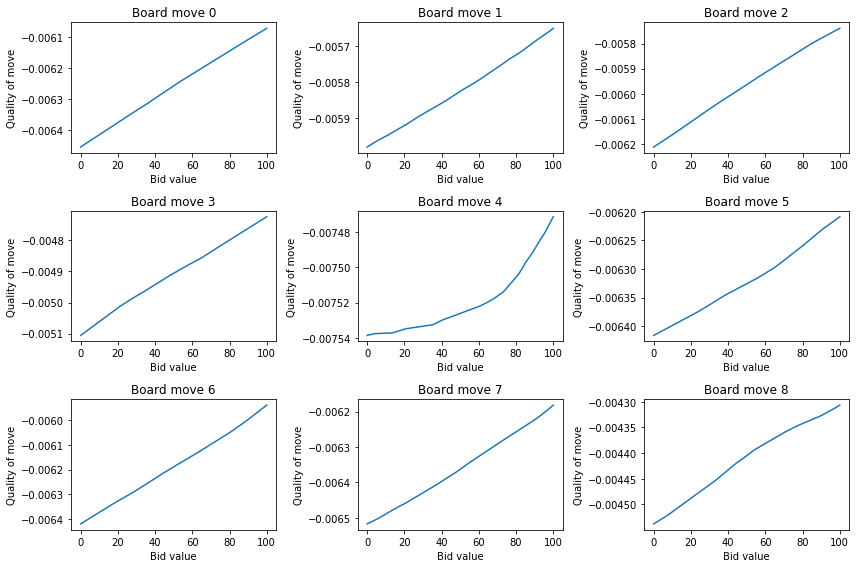

Animation of critic values saved!
Episode #6600  |  Val. Score: +0.70   |  Avg. Val. Score: +0.13  |  Epsilon: 0.010
                  Actor Loss: -1.570  |  Critic Loss: +0.279     |  Time Elapsed: 3924.75s
Episode #6700  |  Val. Score: +0.40   |  Avg. Val. Score: +0.14  |  Epsilon: 0.010
                  Actor Loss: -1.488  |  Critic Loss: +0.260     |  Time Elapsed: 3982.88s
Episode #6800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.15  |  Epsilon: 0.010
                  Actor Loss: -1.418  |  Critic Loss: +0.235     |  Time Elapsed: 4036.81s
Episode #6900  |  Val. Score: +0.70   |  Avg. Val. Score: +0.15  |  Epsilon: 0.010
                  Actor Loss: -1.359  |  Critic Loss: +0.214     |  Time Elapsed: 4092.32s
Episode #7000  |  Val. Score: +0.40   |  Avg. Val. Score: +0.16  |  Epsilon: 0.010
                  Actor Loss: -1.321  |  Critic Loss: +0.197     |  Time Elapsed: 4148.04s
Checkpoint saved!


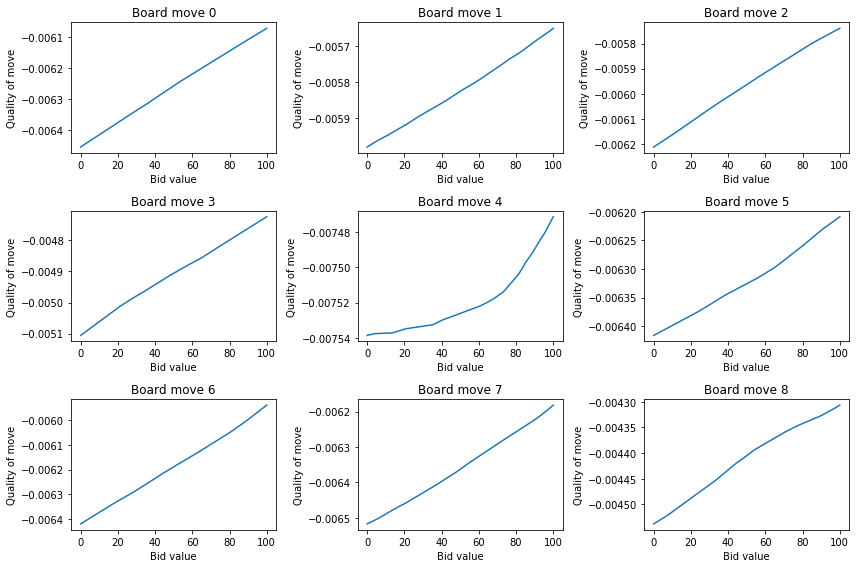

Animation of critic values saved!
Episode #7100  |  Val. Score: +0.50   |  Avg. Val. Score: +0.16  |  Epsilon: 0.010
                  Actor Loss: -1.306  |  Critic Loss: +0.172     |  Time Elapsed: 4229.95s
Episode #7200  |  Val. Score: +0.20   |  Avg. Val. Score: +0.16  |  Epsilon: 0.010
                  Actor Loss: -1.229  |  Critic Loss: +0.207     |  Time Elapsed: 4283.37s
Episode #7300  |  Val. Score: -0.20   |  Avg. Val. Score: +0.16  |  Epsilon: 0.010
                  Actor Loss: -1.213  |  Critic Loss: +0.188     |  Time Elapsed: 4339.94s
Episode #7400  |  Val. Score: +0.40   |  Avg. Val. Score: +0.16  |  Epsilon: 0.010
                  Actor Loss: -1.182  |  Critic Loss: +0.175     |  Time Elapsed: 4399.84s
Episode #7500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.17  |  Epsilon: 0.010
                  Actor Loss: -1.180  |  Critic Loss: +0.172     |  Time Elapsed: 4458.48s
Checkpoint saved!


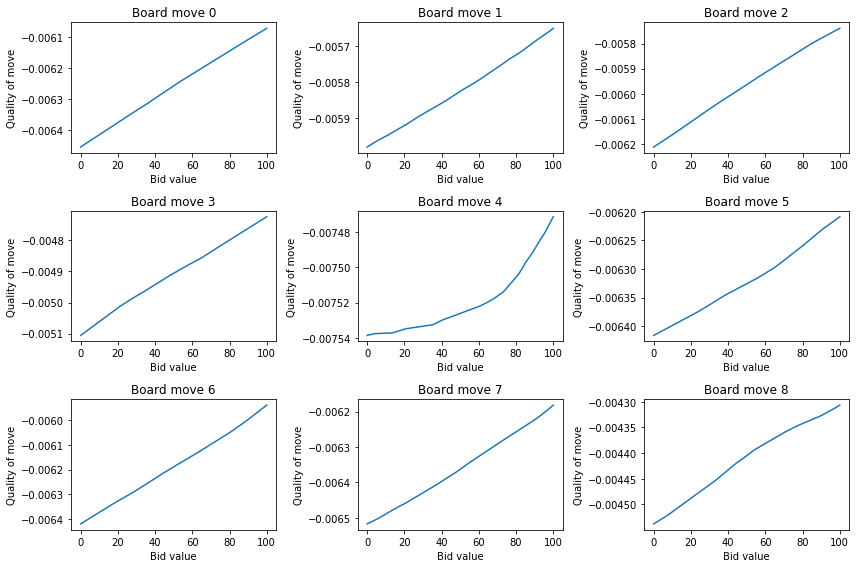

Animation of critic values saved!
Episode #7600  |  Val. Score: +0.50   |  Avg. Val. Score: +0.18  |  Epsilon: 0.010
                  Actor Loss: -1.157  |  Critic Loss: +0.149     |  Time Elapsed: 4548.90s
Episode #7700  |  Val. Score: +0.40   |  Avg. Val. Score: +0.18  |  Epsilon: 0.010
                  Actor Loss: -1.190  |  Critic Loss: +0.152     |  Time Elapsed: 4608.07s
Episode #7800  |  Val. Score: +0.40   |  Avg. Val. Score: +0.18  |  Epsilon: 0.010
                  Actor Loss: -1.159  |  Critic Loss: +0.186     |  Time Elapsed: 4669.51s
Episode #7900  |  Val. Score: +0.40   |  Avg. Val. Score: +0.18  |  Epsilon: 0.010
                  Actor Loss: -1.199  |  Critic Loss: +0.153     |  Time Elapsed: 4728.45s
Episode #8000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.19  |  Epsilon: 0.010
                  Actor Loss: -1.157  |  Critic Loss: +0.142     |  Time Elapsed: 4787.83s
Checkpoint saved!


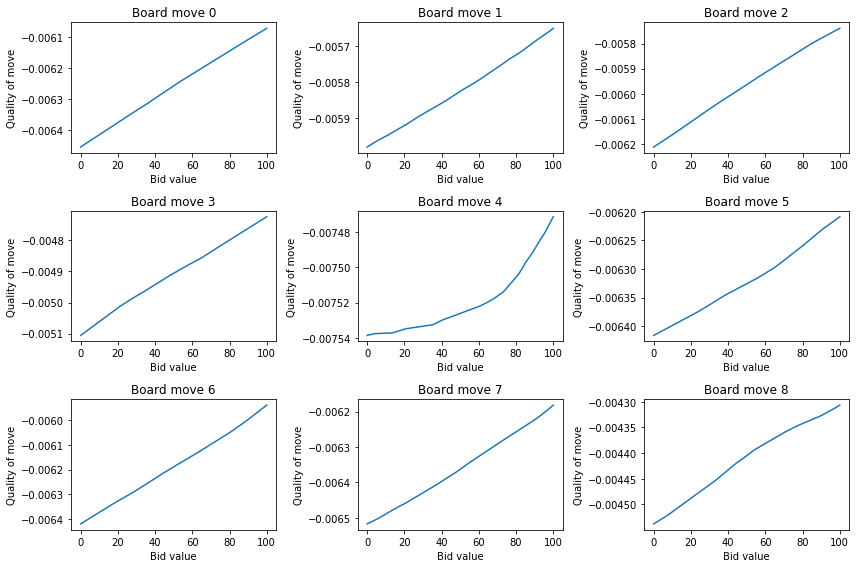

Animation of critic values saved!
Episode #8100  |  Val. Score: +0.90   |  Avg. Val. Score: +0.20  |  Epsilon: 0.010
                  Actor Loss: -1.168  |  Critic Loss: +0.146     |  Time Elapsed: 4881.29s
Episode #8200  |  Val. Score: +0.70   |  Avg. Val. Score: +0.21  |  Epsilon: 0.010
                  Actor Loss: -1.147  |  Critic Loss: +0.165     |  Time Elapsed: 4940.87s
Episode #8300  |  Val. Score: +0.50   |  Avg. Val. Score: +0.21  |  Epsilon: 0.010
                  Actor Loss: -1.144  |  Critic Loss: +0.149     |  Time Elapsed: 5001.13s
Episode #8400  |  Val. Score: +0.50   |  Avg. Val. Score: +0.22  |  Epsilon: 0.010
                  Actor Loss: -1.134  |  Critic Loss: +0.132     |  Time Elapsed: 5059.62s
Episode #8500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.22  |  Epsilon: 0.010
                  Actor Loss: -1.162  |  Critic Loss: +0.157     |  Time Elapsed: 5119.01s
Checkpoint saved!


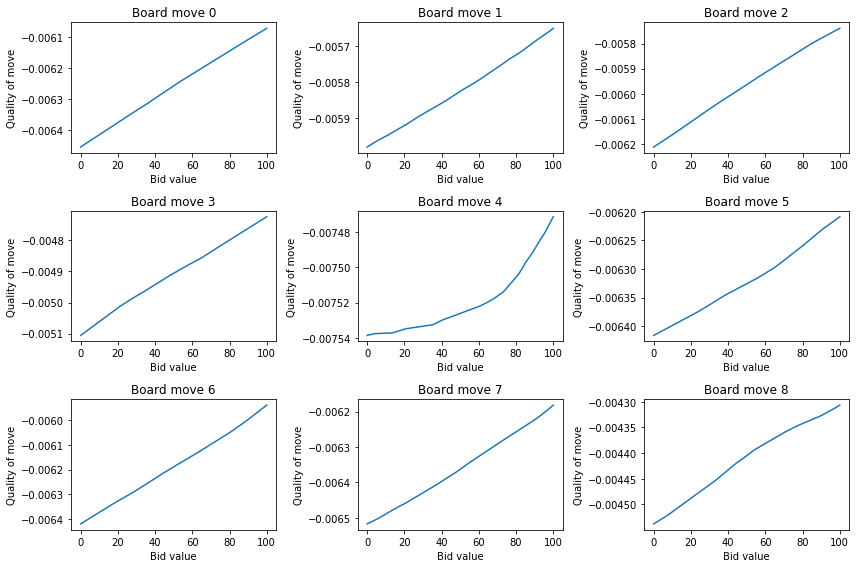

Animation of critic values saved!
Episode #8600  |  Val. Score: +0.40   |  Avg. Val. Score: +0.22  |  Epsilon: 0.010
                  Actor Loss: -1.159  |  Critic Loss: +0.127     |  Time Elapsed: 5214.27s
Episode #8700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.23  |  Epsilon: 0.010
                  Actor Loss: -1.152  |  Critic Loss: +0.152     |  Time Elapsed: 5271.78s
Episode #8800  |  Val. Score: +0.40   |  Avg. Val. Score: +0.23  |  Epsilon: 0.010
                  Actor Loss: -1.160  |  Critic Loss: +0.141     |  Time Elapsed: 5327.23s
Episode #8900  |  Val. Score: +0.20   |  Avg. Val. Score: +0.23  |  Epsilon: 0.010
                  Actor Loss: -1.143  |  Critic Loss: +0.159     |  Time Elapsed: 5383.82s
Episode #9000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.24  |  Epsilon: 0.010
                  Actor Loss: -1.162  |  Critic Loss: +0.151     |  Time Elapsed: 5439.31s
Checkpoint saved!


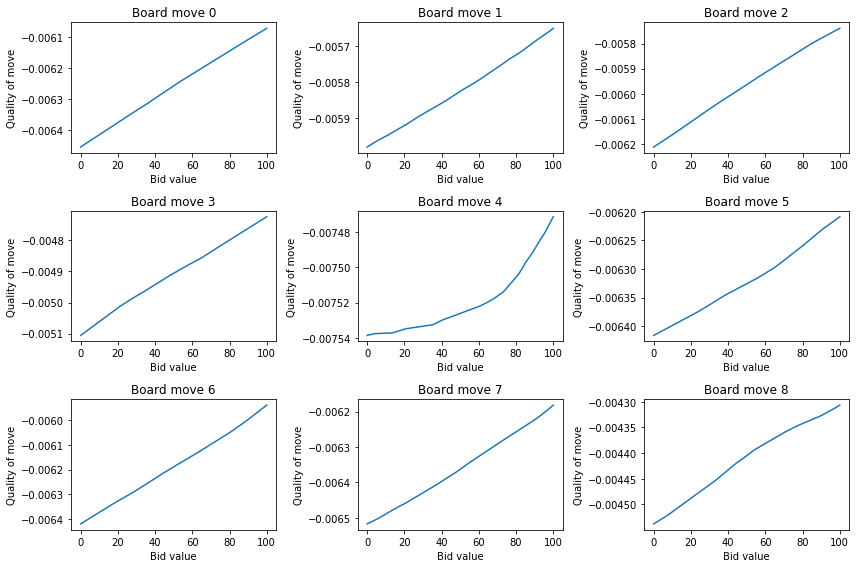

Animation of critic values saved!
Episode #9100  |  Val. Score: +0.20   |  Avg. Val. Score: +0.24  |  Epsilon: 0.010
                  Actor Loss: -1.129  |  Critic Loss: +0.161     |  Time Elapsed: 5531.38s
Episode #9200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.24  |  Epsilon: 0.010
                  Actor Loss: -1.133  |  Critic Loss: +0.145     |  Time Elapsed: 5585.82s
Episode #9300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.25  |  Epsilon: 0.010
                  Actor Loss: -1.169  |  Critic Loss: +0.133     |  Time Elapsed: 5642.99s
Episode #9400  |  Val. Score: +0.40   |  Avg. Val. Score: +0.25  |  Epsilon: 0.010
                  Actor Loss: -1.165  |  Critic Loss: +0.132     |  Time Elapsed: 5700.47s
Episode #9500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.26  |  Epsilon: 0.010
                  Actor Loss: -1.149  |  Critic Loss: +0.148     |  Time Elapsed: 5758.66s
Checkpoint saved!


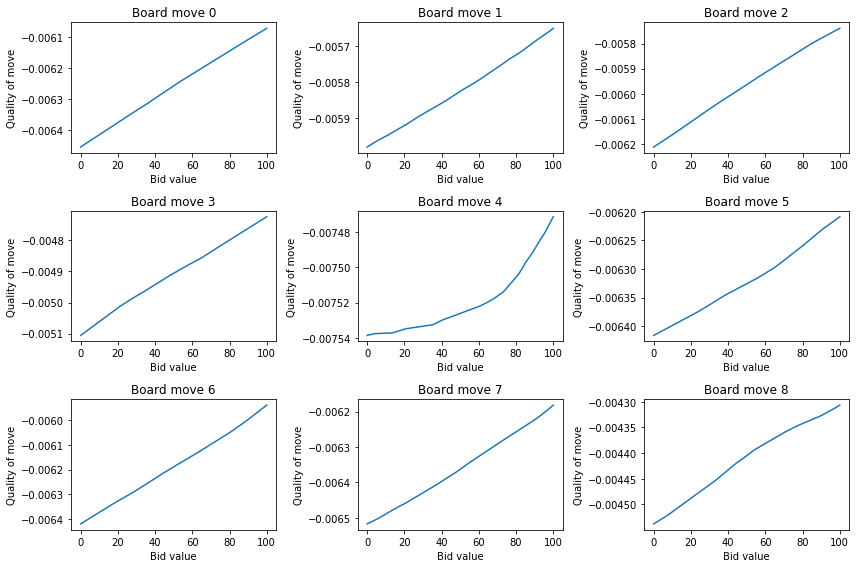

Animation of critic values saved!
Episode #9600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.26  |  Epsilon: 0.010
                  Actor Loss: -1.186  |  Critic Loss: +0.152     |  Time Elapsed: 5855.24s
Episode #9700  |  Val. Score: +0.50   |  Avg. Val. Score: +0.26  |  Epsilon: 0.010
                  Actor Loss: -1.173  |  Critic Loss: +0.135     |  Time Elapsed: 5910.85s
Episode #9800  |  Val. Score: +0.00   |  Avg. Val. Score: +0.26  |  Epsilon: 0.010
                  Actor Loss: -1.175  |  Critic Loss: +0.125     |  Time Elapsed: 5969.00s
Episode #9900  |  Val. Score: +0.30   |  Avg. Val. Score: +0.26  |  Epsilon: 0.010
                  Actor Loss: -1.135  |  Critic Loss: +0.155     |  Time Elapsed: 6025.56s
Episode #10000  |  Val. Score: +0.20   |  Avg. Val. Score: +0.26  |  Epsilon: 0.010
                  Actor Loss: -1.150  |  Critic Loss: +0.138     |  Time Elapsed: 6083.53s
Checkpoint saved!


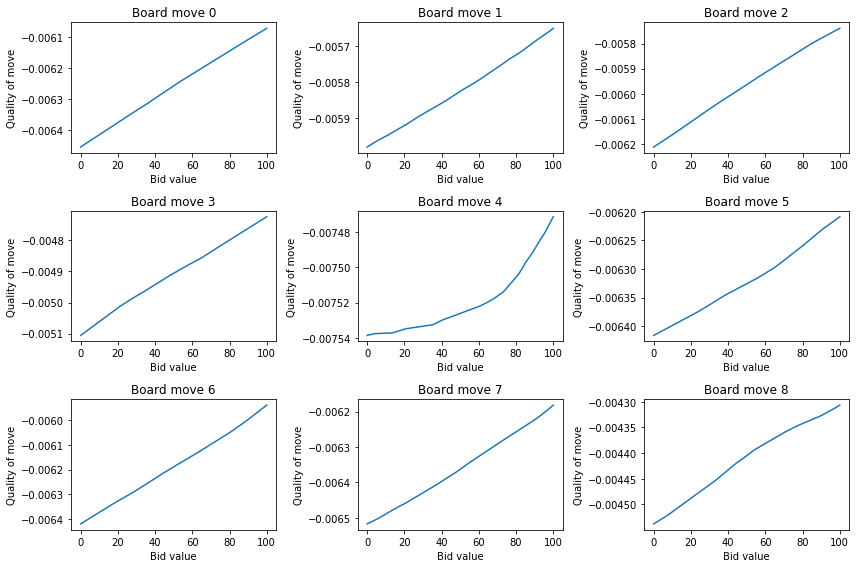

Animation of critic values saved!
Model saved!


In [10]:
n_episodes=10000
checkpoint_each=500
validate_each=100
n_episodes_validation=10
save_critic_value_each=100
save_animation_each=500
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.999
players = [
    DRLPlayer(0, controller.game, drl_agent, train_mode=True),
    RandomPlayer(1)
]
validation_scores, critic_values_by_episode = init_train(controller, players, model_path='../checkpoints/model_v3.pt',
                    n_episodes=n_episodes, checkpoint_each=checkpoint_each, validate_each=validate_each,
                    n_episodes_validation=n_episodes_validation, save_animation_each=save_animation_each,
                    save_critic_value_each=save_critic_value_each, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)


In [11]:
len(critic_values_by_episode)

100

In [21]:
final_validation_scores = validation_scores
final_critic_values_by_episode = critic_values_by_episode

Episode #24300  |  Val. Score: -0.90   |  Avg. Val. Score: -0.90  |  Epsilon: 0.010
                  Actor Loss: -15.252  |  Critic Loss: +25.786     |  Time Elapsed: 152.91s
Episode #24400  |  Val. Score: -0.20   |  Avg. Val. Score: -0.55  |  Epsilon: 0.010
                  Actor Loss: -15.639  |  Critic Loss: +28.425     |  Time Elapsed: 305.88s
Episode #24500  |  Val. Score: +0.30   |  Avg. Val. Score: -0.27  |  Epsilon: 0.010
                  Actor Loss: -15.844  |  Critic Loss: +26.145     |  Time Elapsed: 462.12s
Checkpoint saved!


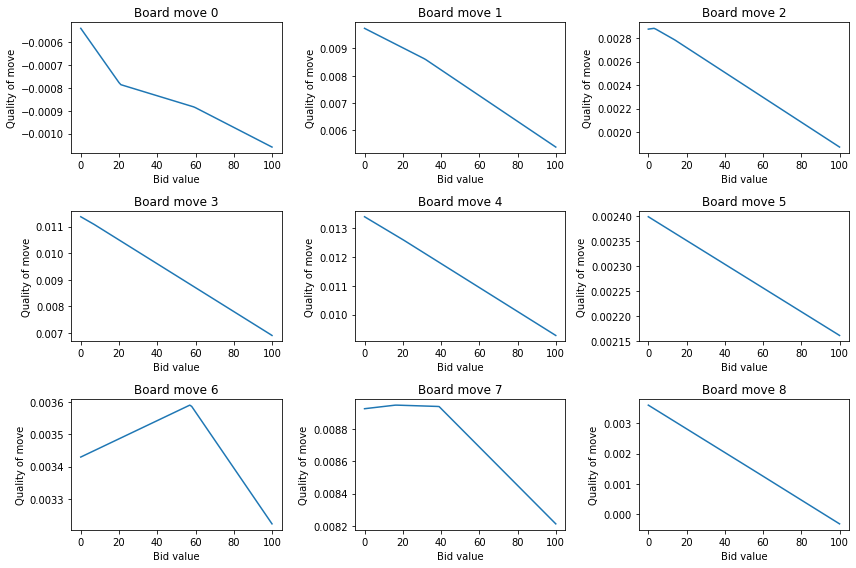

Animation of critic values saved!
Episode #24600  |  Val. Score: -0.10   |  Avg. Val. Score: -0.23  |  Epsilon: 0.010
                  Actor Loss: -15.800  |  Critic Loss: +25.193     |  Time Elapsed: 901.74s
Episode #24700  |  Val. Score: -0.20   |  Avg. Val. Score: -0.22  |  Epsilon: 0.010
                  Actor Loss: -15.421  |  Critic Loss: +23.078     |  Time Elapsed: 1057.98s
Episode #24800  |  Val. Score: +0.20   |  Avg. Val. Score: -0.15  |  Epsilon: 0.010
                  Actor Loss: -15.390  |  Critic Loss: +23.157     |  Time Elapsed: 1213.88s
Episode #24900  |  Val. Score: +0.30   |  Avg. Val. Score: -0.09  |  Epsilon: 0.010
                  Actor Loss: -15.460  |  Critic Loss: +25.744     |  Time Elapsed: 1353.47s
Episode #25000  |  Val. Score: +0.00   |  Avg. Val. Score: -0.08  |  Epsilon: 0.010
                  Actor Loss: -15.617  |  Critic Loss: +25.392     |  Time Elapsed: 1507.42s
Checkpoint saved!


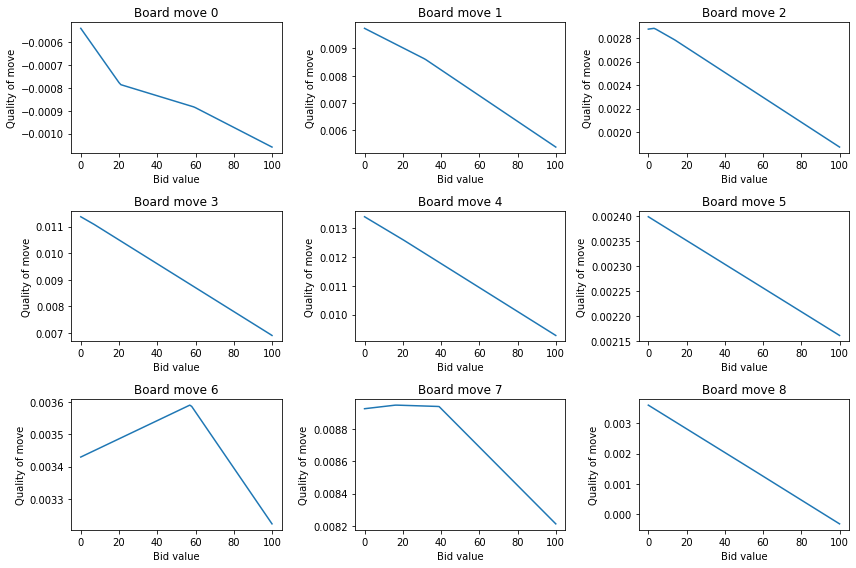

Animation of critic values saved!
Episode #25100  |  Val. Score: +0.10   |  Avg. Val. Score: -0.06  |  Epsilon: 0.010
                  Actor Loss: -15.870  |  Critic Loss: +23.079     |  Time Elapsed: 1944.96s
Episode #25200  |  Val. Score: -0.20   |  Avg. Val. Score: -0.07  |  Epsilon: 0.010
                  Actor Loss: -15.364  |  Critic Loss: +25.336     |  Time Elapsed: 2095.03s
Episode #25300  |  Val. Score: +0.20   |  Avg. Val. Score: -0.05  |  Epsilon: 0.010
                  Actor Loss: -15.014  |  Critic Loss: +24.488     |  Time Elapsed: 2198.40s
Episode #25400  |  Val. Score: -0.30   |  Avg. Val. Score: -0.07  |  Epsilon: 0.010
                  Actor Loss: -14.883  |  Critic Loss: +25.132     |  Time Elapsed: 2296.03s
Episode #25500  |  Val. Score: -0.30   |  Avg. Val. Score: -0.08  |  Epsilon: 0.010
                  Actor Loss: -14.603  |  Critic Loss: +23.742     |  Time Elapsed: 2396.01s
Checkpoint saved!


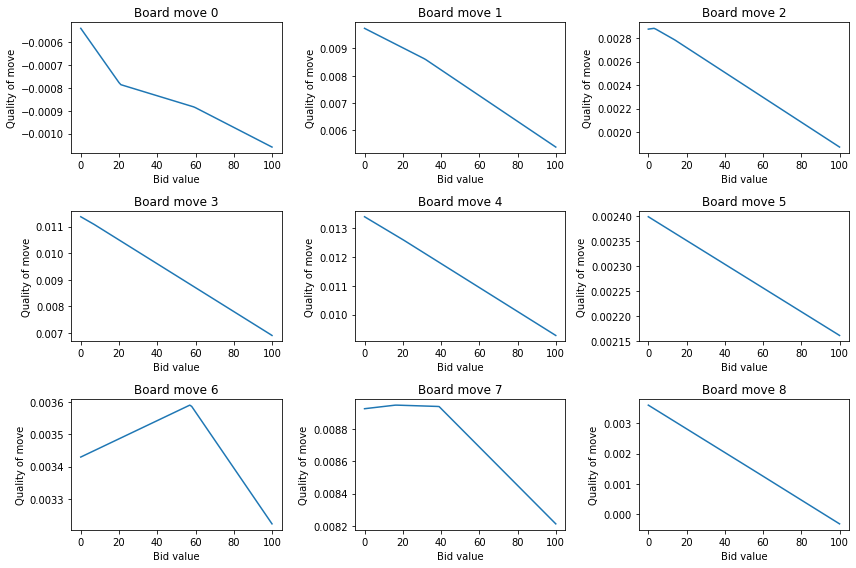

Animation of critic values saved!
Episode #25600  |  Val. Score: -0.60   |  Avg. Val. Score: -0.12  |  Epsilon: 0.010
                  Actor Loss: -14.335  |  Critic Loss: +22.918     |  Time Elapsed: 2782.03s
Episode #25700  |  Val. Score: -0.30   |  Avg. Val. Score: -0.13  |  Epsilon: 0.010
                  Actor Loss: -14.195  |  Critic Loss: +21.090     |  Time Elapsed: 2902.24s
Episode #25800  |  Val. Score: -0.20   |  Avg. Val. Score: -0.14  |  Epsilon: 0.010
                  Actor Loss: -13.914  |  Critic Loss: +18.205     |  Time Elapsed: 3061.52s
Episode #25900  |  Val. Score: -0.20   |  Avg. Val. Score: -0.14  |  Epsilon: 0.010
                  Actor Loss: -13.311  |  Critic Loss: +19.431     |  Time Elapsed: 3220.73s
Episode #26000  |  Val. Score: -0.10   |  Avg. Val. Score: -0.14  |  Epsilon: 0.010
                  Actor Loss: -12.896  |  Critic Loss: +18.569     |  Time Elapsed: 3382.49s
Checkpoint saved!


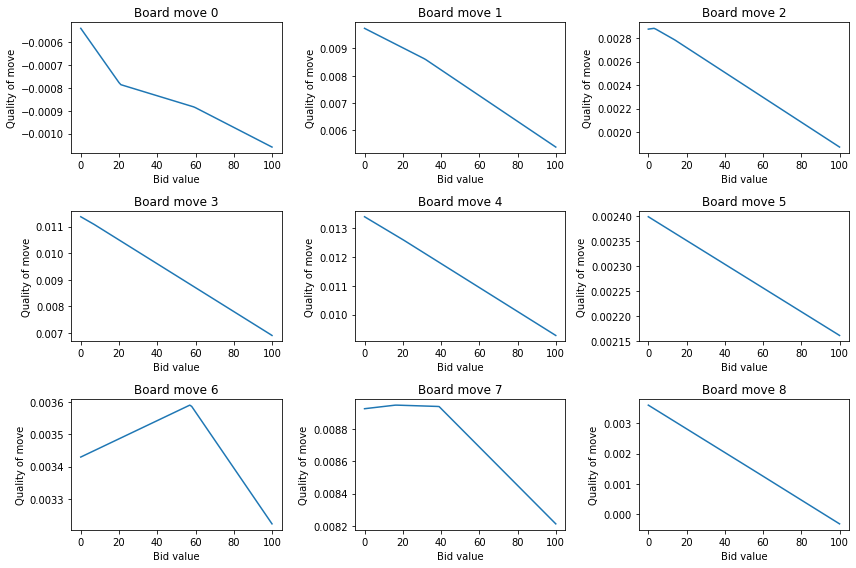

In [ ]:
# Continue training
validation_scores_continued, critic_values_by_episode_continued = init_train(controller, players,
                    start_epoch=24201, critic_values_by_episode=critic_values_by_episode, model_path='../checkpoints/model_v3.pt',
                    n_episodes=5800, checkpoint_each=checkpoint_each, validate_each=validate_each,
                    n_episodes_validation=n_episodes_validation, save_animation_each=save_animation_each,
                    save_critic_value_each=save_critic_value_each, eps_start=0.01, eps_end=eps_end, eps_decay=eps_decay)

In [ ]:
final_validation_scores += validation_scores_continued
final_critic_values_by_episode += critic_values_by_episode_continued

In [ ]:
plot_scores(final_validation_scores, validate_each)

In [ ]:
drl_agent.save_model('../checkpoints/model_final_v3.pt')

In [ ]:
# Plot loss functions
losses = drl_agent.get_losses()
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(losses['actor_losses'], label='actor_losses')
ax.plot(losses['critic_losses'], label='critic_losses')
ax.set_xlabel('No. of Agent moves')
ax.set_ylabel('Loss')
# ax.plot(list((critic_loss - actor_loss) for critic_loss, actor_loss in zip(losses['critic_losses'][:], losses['actor_losses'][:])), label='diff_losses')
plt.legend(loc='best')
plt.show();

In [28]:
controller.reset_game(drl_checkpoint_path='../checkpoints/model_v3.pt')

Select one of the following players to be player 1
0 - ./models/players\drl_player.py
1 - ./models/players\human_player.py
2 - ./models/players\random_player.py
Input desired player number: 0
current directory: C:\Users\tiago\dev\ufrj\gambling-tic-tac-toe\src
initial_checkpoint_path: ../checkpoints/checkpoint2.pt
self.t_step 4
Select one of the following players to be player 2
0 - ./models/players\drl_player.py
1 - ./models/players\human_player.py
2 - ./models/players\random_player.py
Input desired player number: 1
                  1 | 2 | 3 
                 ---+---+---
                  4 | 5 | 6 
                 ---+---+---
                  7 | 8 | 9 
Player 1 (X): 100           Player 2 (O): 100

Player 1 DRLPlayer(X) bidding...
Player 2 HumanPlayer(O) bidding...
50
Player 1 DRLPlayer(X) bid: 75  |  Player 2 HumanPlayer(O) bid: 50  |  
Player 1 DRLPlayer(X) won the bet
                  1 | 2 | 3 
                 ---+---+---
                  4 | 5 | 6 
                 ---+---